In [1]:
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, TimeRangeRunSpec, do_coarse_to_fine, initialize_from, do_inference, initialize_sg
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.graph.region import Region

import os, sys, traceback
import cPickle as pickle

%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.models.ttime import tt_predict
from sigvisa.utils.array import time_to_index, index_to_time

from sigvisa.infer.correlations.ar_correlation_model import ar_advantage

from sigvisa.infer.template_xc import *

In [2]:
with open("/home/dmoore/python/sigvisa/logs/mcmc/01098.1.1.1/step_000385/pickle.sg", 'rb') as f:
    sg = pickle.load(f)

In [3]:
eid = 16
phase = "Lg"
sta="NV01"
wn = sg.get_arrival_wn(sta, eid, phase, band=None, chan=None)

tmnodes = sg.get_template_nodes(eid, wn.sta, phase, wn.band, wn.chan)





/home/dmoore/python/sigvisa/models/signal_model.py:602: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [7]:
def atime_proposal_distribution_from_xc(sg, eid_src, eid_target, phase,
                                        wn_src, wn_target,
                                        temp=1.0):

    if wn_target.srate != wn_src.srate:
        raise Exception("cross-correlation requires matching srates")
    srate = float(wn_target.srate)

    # load 10s immediately following the *current hypothesized arrival
    # time* for the source event.
    signal_src, idx_src, stime_src = get_arrival_signal(sg, eid_src, phase, wn_src,
                                                        pre_s=0.0, post_s=10.0,
                                                        pred_atime=False)

    # load a 40s time period around the *predicted* arrival time for
    # the target event. (using the current hypothesis would require
    # us to use a different window for the backwards proposal, since
    # the proposal will change the hypothesis, whereas the predicted
    # time is unchanged).
    pre_s = 15.0
    post_s = 25.0
    signal_target, idx_target, stime_target = get_arrival_signal(sg, eid_target, phase, wn_target,
                                                                 pre_s=pre_s, post_s=post_s,
                                                                 pred_atime=True)

    # slide the source arrival over the target
    xc = fastxc(signal_src, signal_target)
    xcdist = np.exp(temp*xc)

    # add a traveltime prior
    target_window_soffset = -pre_s + idx_target/srate
    target_window_eoffset = target_window_soffset + len(xc)/srate
    x = np.linspace(target_window_soffset, target_window_eoffset, len(xc))
    prior = np.exp(-np.abs(x/3.0))

    xcdist *= prior
    xcdist /= np.sum(xcdist)

    def idx_to_atime(idx):
        # if src signal was clipped, this will give us the
        # *correct* target index at which the arrival should
        # start
        st_idx = idx-idx_src

        atime = stime_target + st_idx/srate
        return atime

    def atime_to_idx(atime):
        # st_idx gives the index into the target window for this atime
        st_idx = time_to_index(atime, stime_target, srate)
        
        # now we correct to get the index we'd expect the source window
        # to align at, given that it might be clipped
        return st_idx+idx_src

    return xcdist, idx_to_atime, atime_to_idx, signal_src, signal_target, xcdist

In [8]:
wn_target = wn
eid_target = eid

k_atime, n_atime = tmnodes['arrival_time']
current_atime = n_atime.get_value(key=k_atime)

relevant_nodes = [wn_target,]
relevant_nodes += [n_atime.parents[n_atime.default_parent_key()],] if n_atime.deterministic() else [n_atime,]

#eid_src, wn_src = sample_xc_source_arrival(sg, eid_target, phase, wn_target.sta, wn_target.band, wn_target.chan)
#print eid_src
eid_src = eid_target
wn_src = wn_target

source_v, _ = wn_src.get_template_params_for_arrival(eid_src, phase)

xcdist, idx_to_atime, atime_to_idx, signal_src, signal_target, xcdist = atime_proposal_distribution_from_xc(sg, eid_src, eid_target, 
                                                                         phase, 
                                                                         wn_src, wn_target, temp=20.0)

proposed_idx = np.random.choice(np.arange(len(xcdist)), p=xcdist)

proposed_atime = idx_to_atime(proposed_idx)

log_qforward = np.log(xcdist[proposed_idx])
backwards_idx = atime_to_idx(current_atime)

log_qbackward = np.log(xcdist[backwards_idx])

#print "atime_xc %s %d: atime %.1f proposing %.1f qf %.1f qb %.1f" % (wn_target.sta, eid, current_atime, proposed_atime, log_qforward, log_qbackward)



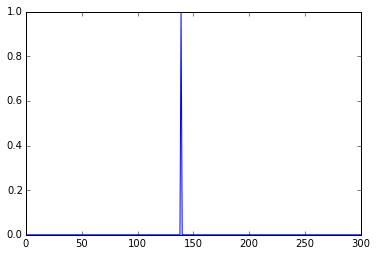

In [9]:
plt.plot(xcdist)

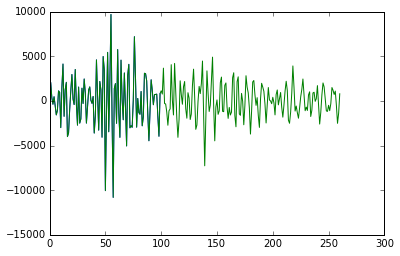

In [36]:

plt.plot(signal_src)
plt.plot(signal_target[proposed_idx:])

In [10]:
print idx_to_atime(proposed_idx)
print current_atime

print proposed_idx
print atime_to_idx(current_atime)

print idx_to_atime(atime_to_idx(current_atime))

1203605310.6
1203605310.65
139
139
1203605310.6


# Current alignment from wave node

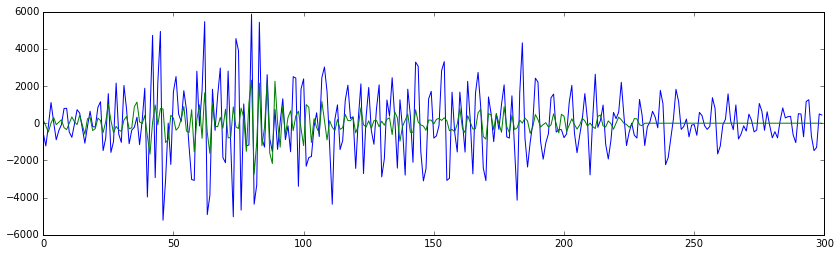

In [58]:
pred_full = wn.tssm.mean_obs(wn.npts)
actual_full = wn.get_value()

plt.figure(figsize=(14, 4))
lg_idx = time_to_index(pred_atime-5.0, wn.st, wn.srate)
plt.plot(actual_full[lg_idx:lg_idx + 300])
plt.plot(pred_full[lg_idx:lg_idx + 300])


# Current alignment in template xc move

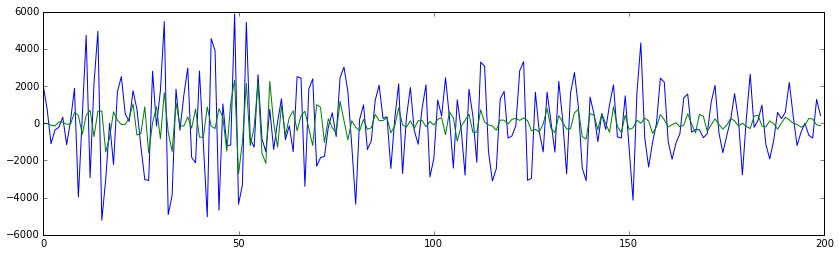

In [59]:
pred_signal = pred_wavelet * env
plt.figure(figsize=(14, 4))
plt.plot(relevant_signal[backwards_idx:backwards_idx + len(pred_signal)])
plt.plot(pred_signal)

# Proposed alignment in template xc move

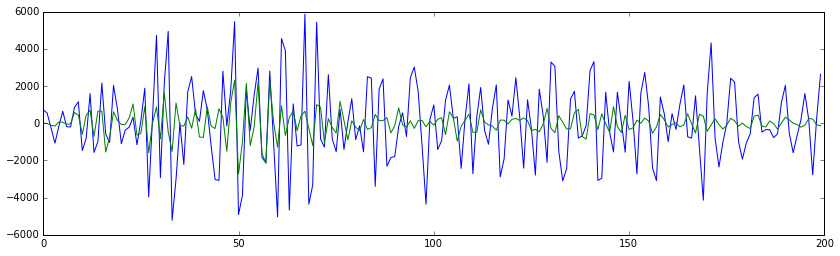

In [60]:
pred_signal = pred_wavelet * env
plt.figure(figsize=(14, 4))
plt.plot(relevant_signal[proposed_idx:proposed_idx + len(pred_signal)])
plt.plot(pred_signal)

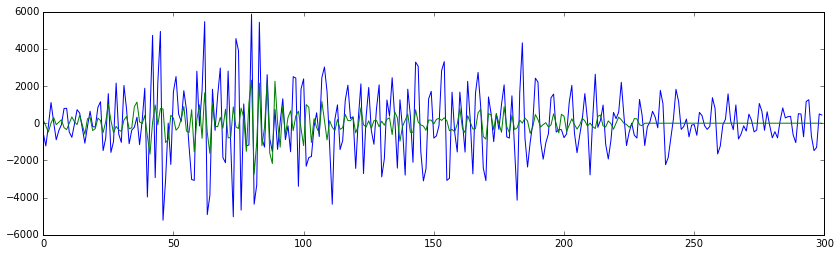

In [61]:
n_atime.set_value(current_atime)

wn._parent_values()

pred_full = wn.tssm.mean_obs(wn.npts)
actual_full = wn.get_value()

plt.figure(figsize=(14, 4))
lg_idx = time_to_index(pred_atime-5.0, wn.st, wn.srate)
plt.plot(actual_full[lg_idx:lg_idx + 300])
plt.plot(pred_full[lg_idx:lg_idx + 300])


In [40]:
for (eeid, pphase, scale, sidx, npts, component_type) in wn.tssm_components:
    if eeid != eid or pphase != phase: continue
    if component_type != "wavelet": continue
    print sidx, npts

807 200


In [42]:
print 807-relevant_sidx

181


In [44]:
print backwards_idx

180


In [48]:
print time_to_index(relevant_stime, wn.st, wn.srate)
print relevant_sidx

626
626


In [51]:
#time_to_index(current_atime, wn.st, wn.srate)

print (current_atime - wn.st) * wn.srate

print (current_atime - relevant_stime) * wn.srate


807.311899662
180.826158524
